In [1]:
import sys, os
sys.path.append(os.path.abspath("../../"))

In [11]:
%matplotlib inline

import numpy as np
from tqdm import tqdm_notebook as tqdm

from winds_no_elements import lib as winds_no_elements
from winds_elements import lib as winds_elements

from tabulation import Lifetimes

import betterplotlib as bpl
bpl.presentation_style()

In [3]:
winds_no_elements.detailed_enrichment_init()
winds_elements.detailed_enrichment_init()

In [4]:
lt = Lifetimes("Raiteri_96")

In [25]:
dt = 1E3

In [26]:
times = dict()
turnoff_masses = dict()
def generate_times(zs):
    for z in zs:
        times[z] = np.arange(0, 50E6, dt)
        turnoff_masses[z] = [lt.turnoff_mass(t, z) for t in tqdm(times[z])]

In [27]:
generate_times([0.02, 0.01, 0.004, 0.001, 0.0005, 0.0001])

# Check the general shape of the wind ejecta

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


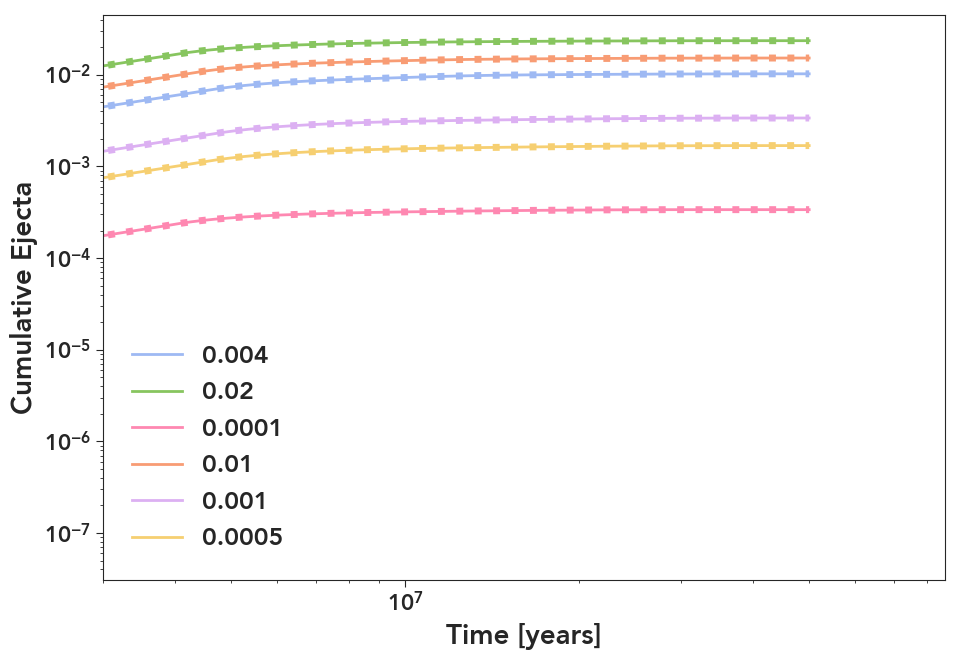

In [43]:
m_star = 1

fig, ax = bpl.subplots()

for idx_z, z in enumerate(times):
    age_50 = lt.lifetime(50.0, z)
    
    cumulative_ejecta_elements = []
    cumulative_ejecta_no_elements = []
    for idx in range(len(times[z])):
        age_now = times[z][idx]
        m_now = turnoff_masses[z][idx]
        
        ejecta_elts = winds_elements.get_cumulative_mass_winds_py(age_now, m_now, z, age_50)
        ejecta_no_elts = winds_no_elements.get_cumulative_mass_winds_py(age_now, m_now, z, age_50)
        
        cumulative_ejecta_elements.append(ejecta_elts)
        cumulative_ejecta_no_elements.append(ejecta_no_elts)
        
    ax.plot(times[z], cumulative_ejecta_elements, lw=2, ls="-", c=bpl.color_cycle[idx_z], label=z)
    ax.plot(times[z], cumulative_ejecta_no_elements, lw=5, ls=":", c=bpl.color_cycle[idx_z])
    

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.add_labels("Time [years]", "Cumulative Ejecta")
# ax.set_limits(3E7, 5E7)
ax.set_limits(x_min=3E6)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


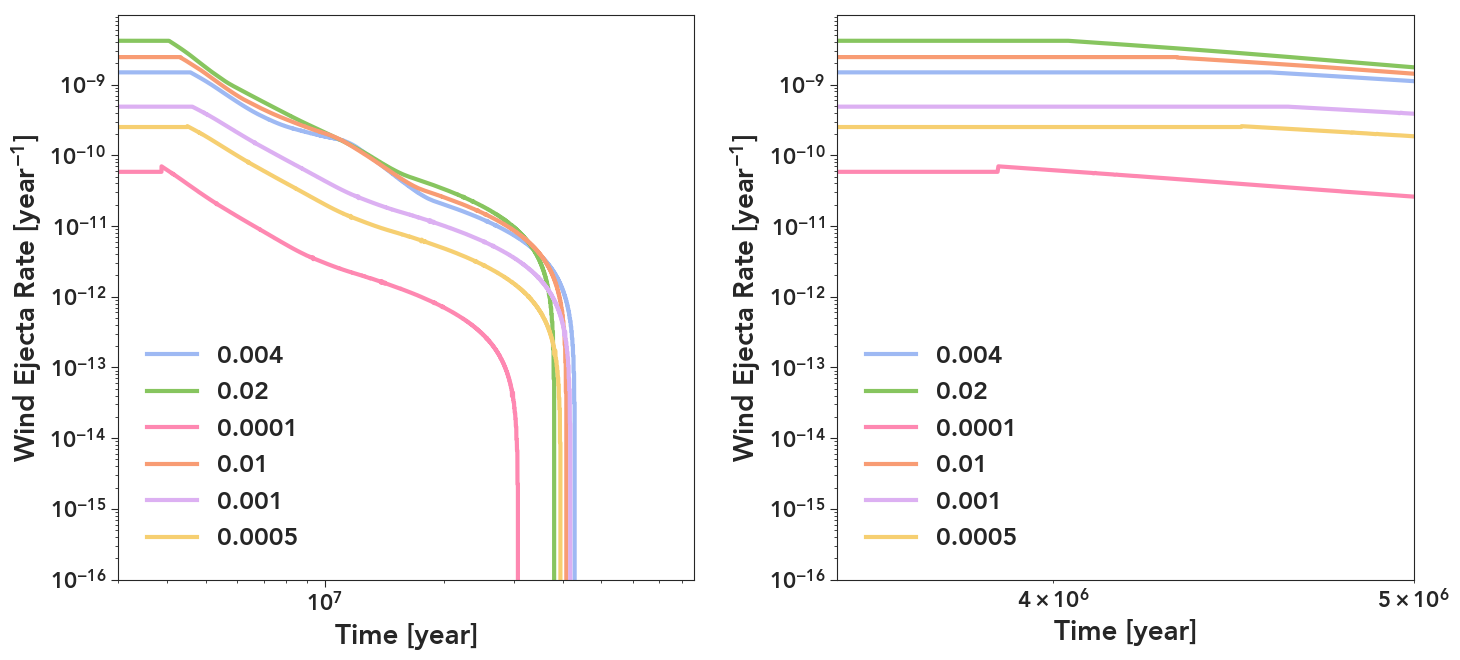

In [49]:
m_star = 1

fig, axs = bpl.subplots(ncols=2, figsize=[15, 7])

for z in times:
    
    age_50 = lt.lifetime(50.0, z)
    
    rates = []
    for idx in range(len(times[z]) - 1):
        age_now = times[z][idx]
        age_next = times[z][idx+1]
        m_now = turnoff_masses[z][idx]
        m_next = turnoff_masses[z][idx+1]
        
        ejecta = winds_elements.get_ejecta_winds_py(age_now, age_next, 
                                                    m_now, m_next, m_star, z, age_50)
        rates.append(ejecta / dt)
    
    for ax in axs:
        ax.plot(times[z][:-1], rates, label=z)
    
for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    ax.add_labels("Time [year]", "Wind Ejecta Rate [year$^{-1}$]")
# axs[1].set_limits(3E7, 5E7)
axs[1].set_limits(3.5E6, 5E6)

axs[0].set_limits(x_min=3E6)

This discreteness isn't a problem. The individual chunks are the segments between two mass points. We linearly interpolate in mass, so the rate with respect to mass should be a constant between the two points. Since the age to mass relation isn't linear, there will be some slight variation in each segment. But this discreteness is an indication that things are working as expected.

In [32]:
rates[-11000:-10000]

[5.635648957051653e-14,
 5.635394603221988e-14,
 5.635139316978455e-14,
 5.634882968216792e-14,
 5.63462661945513e-14,
 5.6343707260583796e-14,
 5.634070250268297e-14,
 5.6340758664355505e-14,
 5.633431373296138e-14,
 5.633346740474554e-14,
 5.633265642152052e-14,
 5.632663584685671e-14,
 5.6325767184076114e-14,
 5.6323175507203006e-14,
 5.632111704095832e-14,
 5.6317525296001315e-14,
 5.6317612682696416e-14,
 4.9119083366661044e-14,
 3.730995352078936e-14,
 3.730774153151706e-14,
 3.730699473306065e-14,
 3.730386052142043e-14,
 3.7302754635204495e-14,
 3.730123328271606e-14,
 3.730073953704671e-14,
 3.729663886758994e-14,
 3.729619239313531e-14,
 3.729407256104767e-14,
 3.729299768301386e-14,
 3.729087481516014e-14,
 3.728899632647609e-14,
 3.7288525132211925e-14,
 3.7285877076825847e-14,
 3.7285040506429555e-14,
 3.728208822391388e-14,
 3.728047232899601e-14,
 3.7279465322018204e-14,
 3.7278085566333497e-14,
 3.727450162763213e-14,
 3.727443765970395e-14,
 3.7272512333486054e-14,
 3.

Examining this carefully shows how the rate has nearly constant values when its between two mass points of the table (with the only variation happening when 

In [34]:
m = 32
age = lt.lifetime(32, z=0.02)
age_50 = lt.lifetime(50, z=0.02)
winds_elements.get_cumulative_mass_winds_py(age, m, z, age_50)


0.0014005690319144673

In [35]:
winds_elements.get_cumulative_mass_winds_py(age, m-0.0001, z, age_50)

0.0014005705215586286

# Test very small fragment of mass range for cumulative winds to check smoothness

In [36]:
z = 0.02
ms = np.linspace(8, 8.1, 1000)
ages = np.array([lt.lifetime(m, z) for m in ms])
age_50 = lt.lifetime(50, z)

In [37]:
ejected_masses = [winds_elements.get_cumulative_mass_winds_py(age, m, z, age_50) 
                  for m, age in zip(ms, ages)]

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


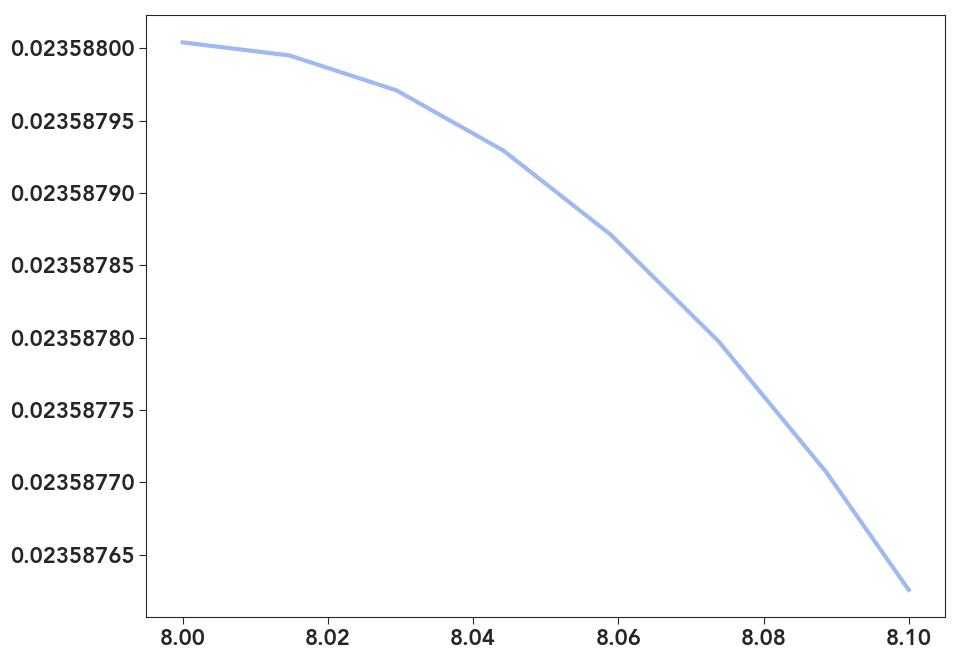

In [38]:
fig, ax = bpl.subplots()
ax.plot(ms, ejected_masses)
# ax.set_limits(35, 34)

# Check what's going on with the bump at early times

In [56]:
z = 0.001
age_50 = lt.lifetime(50.0, z)

In [57]:
ms = np.linspace(49.5, 50.5, 1000)
ejected_masses = []
for m in ms:
    age = lt.lifetime(m, z)
    ejected = winds_elements.get_cumulative_mass_winds_py(age, m, z, age_50)
    ejected_masses.append(ejected)

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


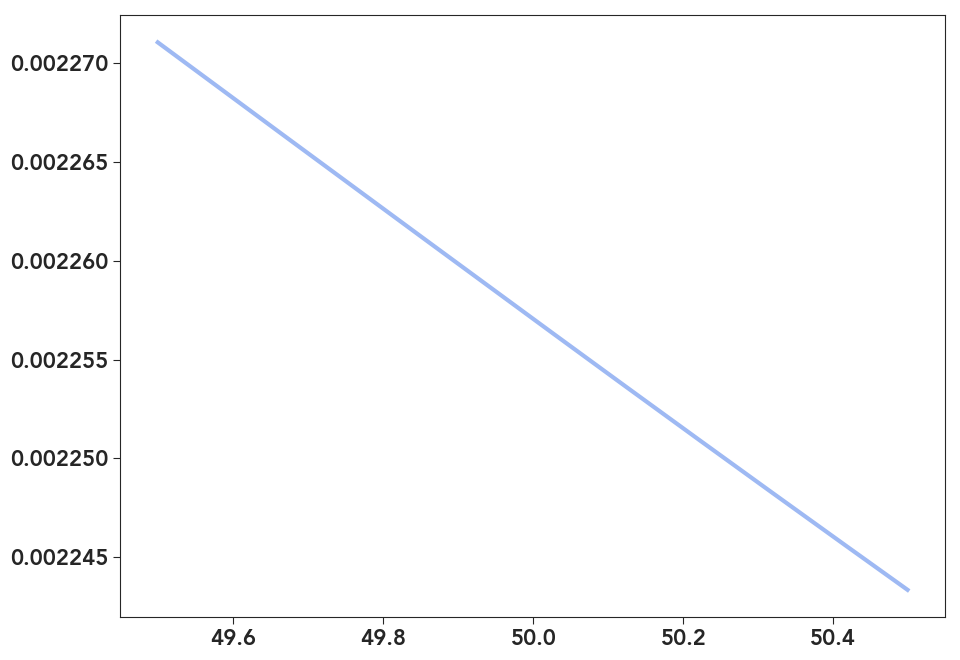

In [58]:
fig, ax = bpl.subplots()
ax.plot(ms, ejected_masses)

In [60]:
a50 = lt.lifetime(50.0, 0.001)
winds_elements.get_cumulative_mass_winds_py(a50, 50.0, 0.001, a50)

0.00225708032